<a href="https://colab.research.google.com/github/costanzagiacona/Progetto-ML/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

from IPython.display import Markdown, display

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Aggiunto import

import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



In [3]:
# Caricamento del dataset MedMNIST-Pneumonia
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File non trovato. Assicurati di aver inserito il percorso corretto dei file NumPy.")
    exit()

In [4]:
# Suddivisione del dataset in set di addestramento, validation e test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()


In [22]:
print("Dimensioni di X:", X.shape)
print("Tipo di dati di X:", X.dtype)
num_samples, height, width, channels = X.shape
print("Numero di campioni:", num_samples)
print("Altezza dell'immagine:", height)
print("Larghezza dell'immagine:", width)
print("Numero di canali dell'immagine:", channels)

Dimensioni di X: (5232, 28, 28)
Tipo di dati di X: uint8
Numero di campioni: 5232
Altezza dell'immagine: 28
Larghezza dell'immagine: 28


In [6]:
# Se le immagini sono in scala di grigi, aggiungi una dimensione per il canale
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [24]:
print("Dimensioni di X:", X_train.shape)
print("Tipo di dati di X:", X_train.dtype)
num_samples, height, width, channels = X_train.shape
print("Numero di campioni:", num_samples)
print("Altezza dell'immagine:", height)
print("Larghezza dell'immagine:", width)
print("Numero di canali dell'immagine:", channels)

Dimensioni di X: (3662, 28, 28, 1)
Tipo di dati di X: uint8
Numero di campioni: 3662
Altezza dell'immagine: 28
Larghezza dell'immagine: 28
Numero di canali dell'immagine: 1


In [7]:
# Modello SVM
svm_model = SVC(random_state=42)
svm_param_grid = {'C': [1], 'kernel': ['rbf']}
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
svm_model_best = svm_grid_search.best_estimator_
svm_pred = svm_model_best.predict(X_validation.reshape(len(X_validation), -1))
svm_accuracy = accuracy_score(y_validation, svm_pred)


In [8]:
# Modello Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)

In [9]:
# Modello CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # 1 classe per la presenza/assenza di polmonite
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))
y_pred_cnn = (model.predict(X_test) > 0.5).astype("int32")
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

Epoch 1/10
115/115 [==============================] - 6s 33ms/step - loss: 1.3038 - accuracy: 0.8572 - val_loss: 0.1745 - val_accuracy: 0.9414
Epoch 2/10
115/115 [==============================] - 4s 37ms/step - loss: 0.1677 - accuracy: 0.9339 - val_loss: 0.1478 - val_accuracy: 0.9503
Epoch 3/10
115/115 [==============================] - 7s 62ms/step - loss: 0.1346 - accuracy: 0.9503 - val_loss: 0.1873 - val_accuracy: 0.9261
Epoch 4/10
115/115 [==============================] - 4s 37ms/step - loss: 0.1231 - accuracy: 0.9530 - val_loss: 0.1173 - val_accuracy: 0.9618
Epoch 5/10
115/115 [==============================] - 3s 29ms/step - loss: 0.1312 - accuracy: 0.9476 - val_loss: 0.1235 - val_accuracy: 0.9490
Epoch 6/10
115/115 [==============================] - 3s 29ms/step - loss: 0.1077 - accuracy: 0.9577 - val_loss: 0.1289 - val_accuracy: 0.9580
Epoch 7/10
115/115 [==============================] - 5s 39ms/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 0.1206 - val_accuracy: 0.9580

In [10]:
# Stampa delle performance
print("Miglior modello SVM:")
print(svm_model_best)
print("Accuracy SVM (validation):", svm_accuracy)
print("Confusion Matrix SVM:")
print(confusion_matrix(y_validation, svm_pred))
print("Classification Report SVM:")
print(classification_report(y_validation, svm_pred))

print("Miglior modello Random Forest:")
print(rf_model_best)
print("Accuracy Random Forest (validation):", rf_accuracy)
print("Confusion Matrix Random Forest:")
print(confusion_matrix(y_validation, rf_pred))
print("Classification Report Random Forest:")
print(classification_report(y_validation, rf_pred))

print("Miglior modello CNN:")
print("Accuracy CNN (test):", accuracy_cnn)
print("Confusion Matrix CNN:")
print(confusion_matrix(y_test, y_pred_cnn))
print("Classification Report CNN:")
print(classification_report(y_test, y_pred_cnn))


Miglior modello SVM:
SVC(C=1, random_state=42)
Accuracy SVM (validation): 0.9528662420382166
Confusion Matrix SVM:
[[193  27]
 [ 10 555]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       220
           1       0.95      0.98      0.97       565

    accuracy                           0.95       785
   macro avg       0.95      0.93      0.94       785
weighted avg       0.95      0.95      0.95       785

Miglior modello Random Forest:
RandomForestClassifier(random_state=42)
Accuracy Random Forest (validation): 0.9426751592356688
Confusion Matrix Random Forest:
[[191  29]
 [ 16 549]]
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       220
           1       0.95      0.97      0.96       565

    accuracy                           0.94       785
   macro avg       0.94      0.92      0.93       785
weighted avg     

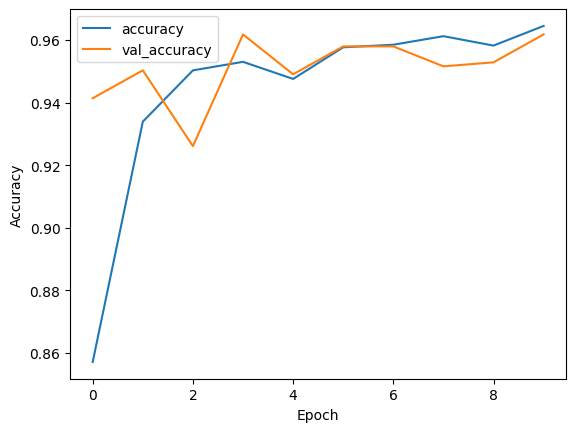

In [11]:
# Visualizzazione dell'andamento dell'accuratezza durante l'addestramento del modello CNN
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


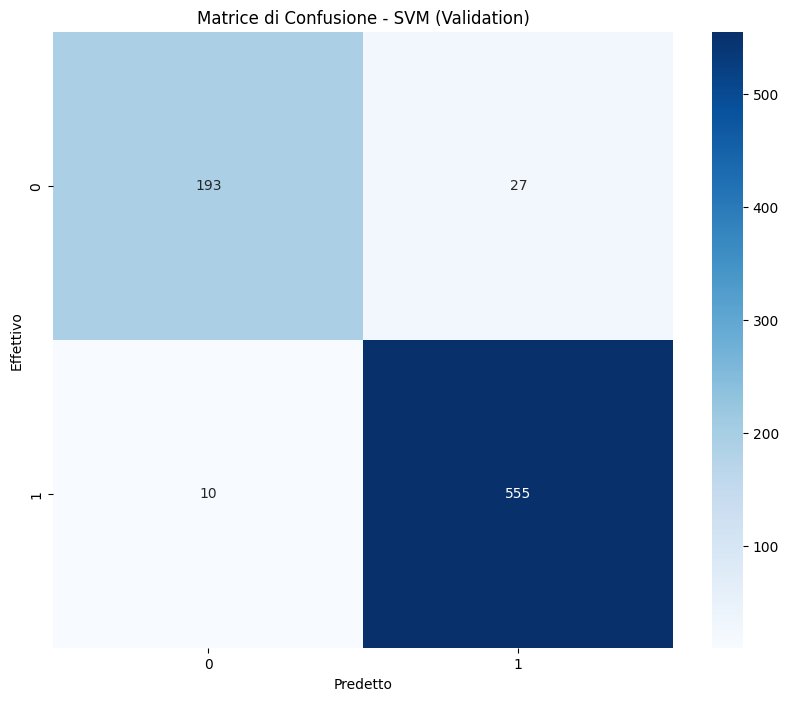

In [12]:
# Visualizzazione delle matrici di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_validation, svm_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione - SVM (Validation)')
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()

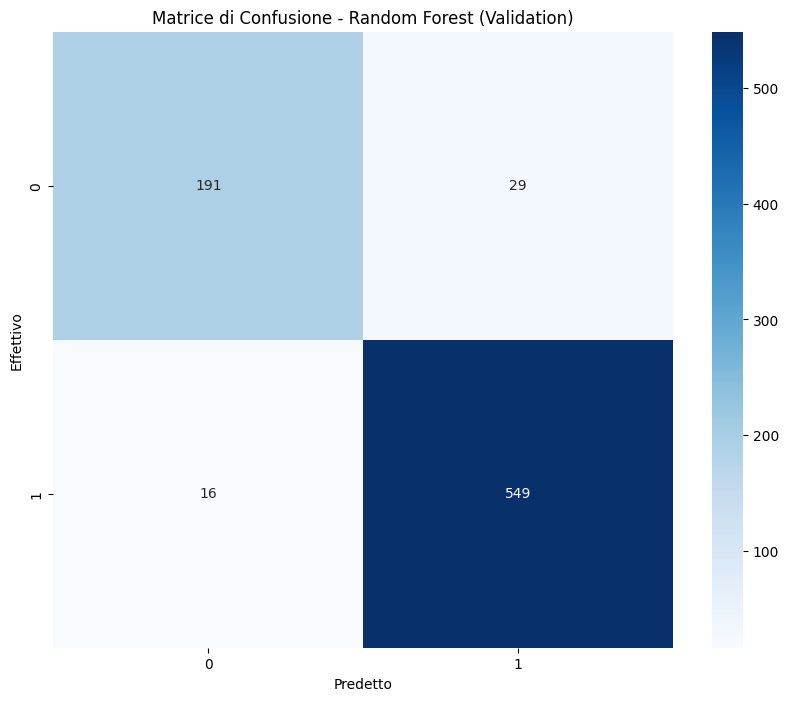

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_validation, rf_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione - Random Forest (Validation)')
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()

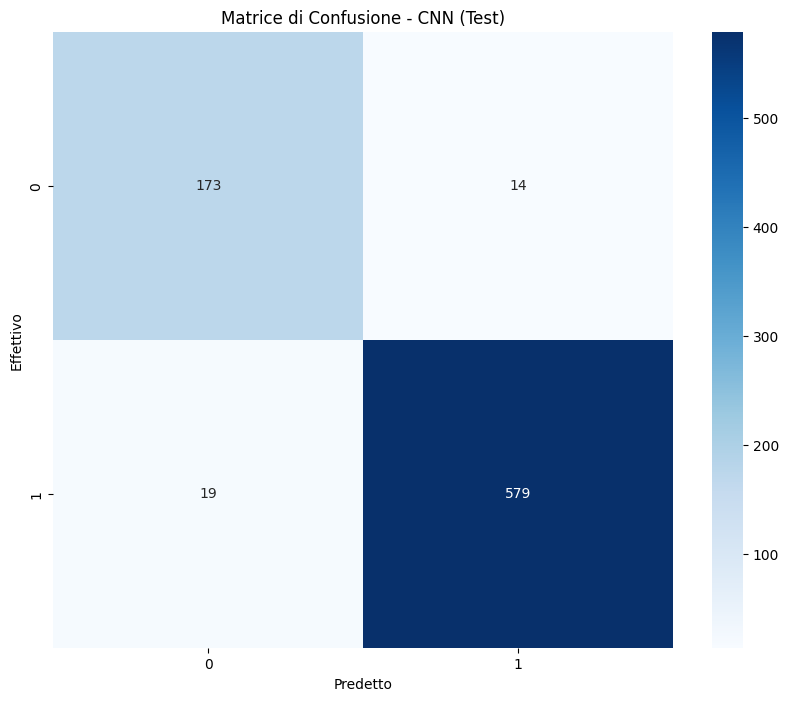

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione - CNN (Test)')
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()

In [ ]:
corr_matrix = np.corrcoef(X.reshape(X.shape[0], -1))

# Creazione della heatmap della matrice di correlazione
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues')
plt.title("Matrice di Correlazione delle Immagini")
plt.show()

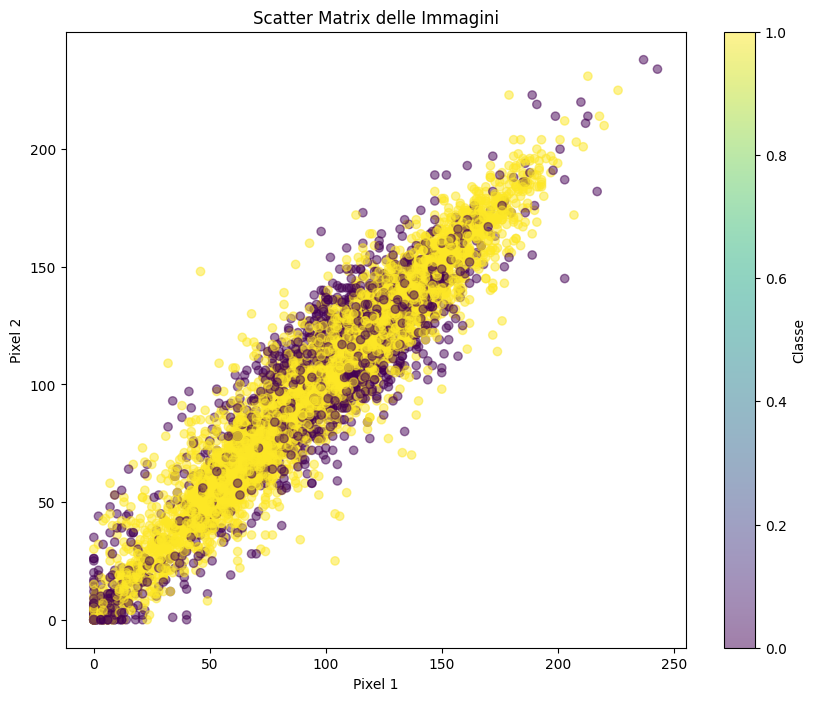

In [16]:
# Riduzione della dimensionalità delle immagini per la scatter matrix
X_reshaped = X.reshape(X.shape[0], -1)  # Appiattiamo le immagini in un vettore

# Creazione della scatter matrix
plt.figure(figsize=(10, 8))
plt.scatter(X_reshaped[:, 0], X_reshaped[:, 1], c=y, cmap='viridis', alpha=0.5)  # Esempio di scatter plot tra i primi due pixel
plt.colorbar(label='Classe')
plt.xlabel('Pixel 1')
plt.ylabel('Pixel 2')
plt.title('Scatter Matrix delle Immagini')
plt.show()